In [1]:
from Models.RCFR_AC_RefLong import SetModel
from Module.DataProcessing import DataLoad
from Module.PostFeatureEval import Components
import venn

import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from numpy import mean as npMean

C:\Users\User\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setting
#### Task types should be established to identify prognostic genes positively or negatively related to survival risk.

In [2]:
PositiveModel = 'M04_RCFR_AC_W0_S3_Epo55.hdf5'
NegativeModel = 'M04_RCFR_AC_W0_S4_Epo27.hdf5'

# Positive vs negative indicator
Positive = False

# Parameters for post-hoc models
EmbedSize = 50
NCL_Feat = 5
NCL_Ind = 2
AdjCosWeight_ = 1. # This parameter affects only training phases, so thus any float number can be set in the post analysis phases. 
NumGene_CL = 100


FilePath = './Results/'

## Component setting
#### Data must be provided in advance. If you do not have data, you must process the data through the previous procedure.

In [3]:
# Data load
StackedData, IntToGene, TTE, EVENT, TrIndEmbeddMask, ReferencePatIDLong, ReferencePatIDShort, NormDismInd, MergedData= DataLoad()


PatIDX = StackedData[:, 0:1].astype('int')
GeneIDX = StackedData[:, 1:2].astype('int')
GeneExp = StackedData[:, 2:3]

IndN = len(np.unique(PatIDX))
FeatN = len(np.unique(GeneIDX))
NCL_Ind = 2  
NCL_Feat = 5

# Model structure load
RCFR_AC, LayerList = SetModel(AdjCosWeight_, NormDismInd, TrIndEmbeddMask, IndN, FeatN, ReferencePatIDLong, ReferencePatIDShort)

# Data for calculating metric
DataMetric = [MergedData, TTE, EVENT, NCL_Ind, NCL_Feat, NumGene_CL, IntToGene]


## Model load by positive or negative model


In [4]:
if Positive:
    model = PositiveModel
else:
    model = NegativeModel


RCFR_AC, LayerList = SetModel(AdjCosWeight_, NormDismInd, TrIndEmbeddMask, IndN, FeatN, ReferencePatIDLong, ReferencePatIDShort)
RCFR_AC.load_weights(FilePath + model)  #M04_RCFR_AC_W20_S4_Epo50.hdf5 #M04_RCFR_AC_W0_S4_Epo27

## Instantiation and identification of commonly expressed genes

{'KIPAN': 1, 'GLIOMA': 1, 'GLIOMA & KIPAN': 2, 'COLO': 135, 'COLO & KIPAN': 58, 'COLO & GLIOMA': 66, 'COLO & GLIOMA & KIPAN': 34, 'BRCA': 0, 'BRCA & KIPAN': 0, 'BRCA & GLIOMA': 0, 'BRCA & GLIOMA & KIPAN': 0, 'BRCA & COLO': 104, 'BRCA & COLO & KIPAN': 35, 'BRCA & COLO & GLIOMA': 42, 'BRCA & COLO & GLIOMA & KIPAN': 19}


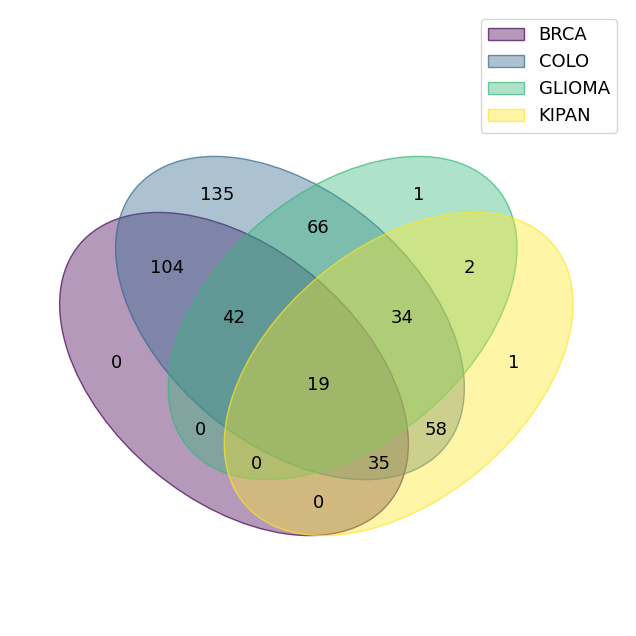

In [5]:
PostAnal = Components(RCFR_AC, LayerList,MergedData,NCL_Ind, NCL_Feat, NumGene_CL, ReferencePatIDLong, ReferencePatIDShort,IntToGene, CancerSet=['BRCA', 'COLO','GLIOMA','KIPAN']) 
PostAnal.CommonSetGene()

if Positive:
    type= 'Pos'
else:
    type='Neg'
#plt.savefig('./Figures/CommonSetGene'+str(type)+'_'+str(NumGene_CL)+'.png')    

## Drawing a survival curve based on the Cox model

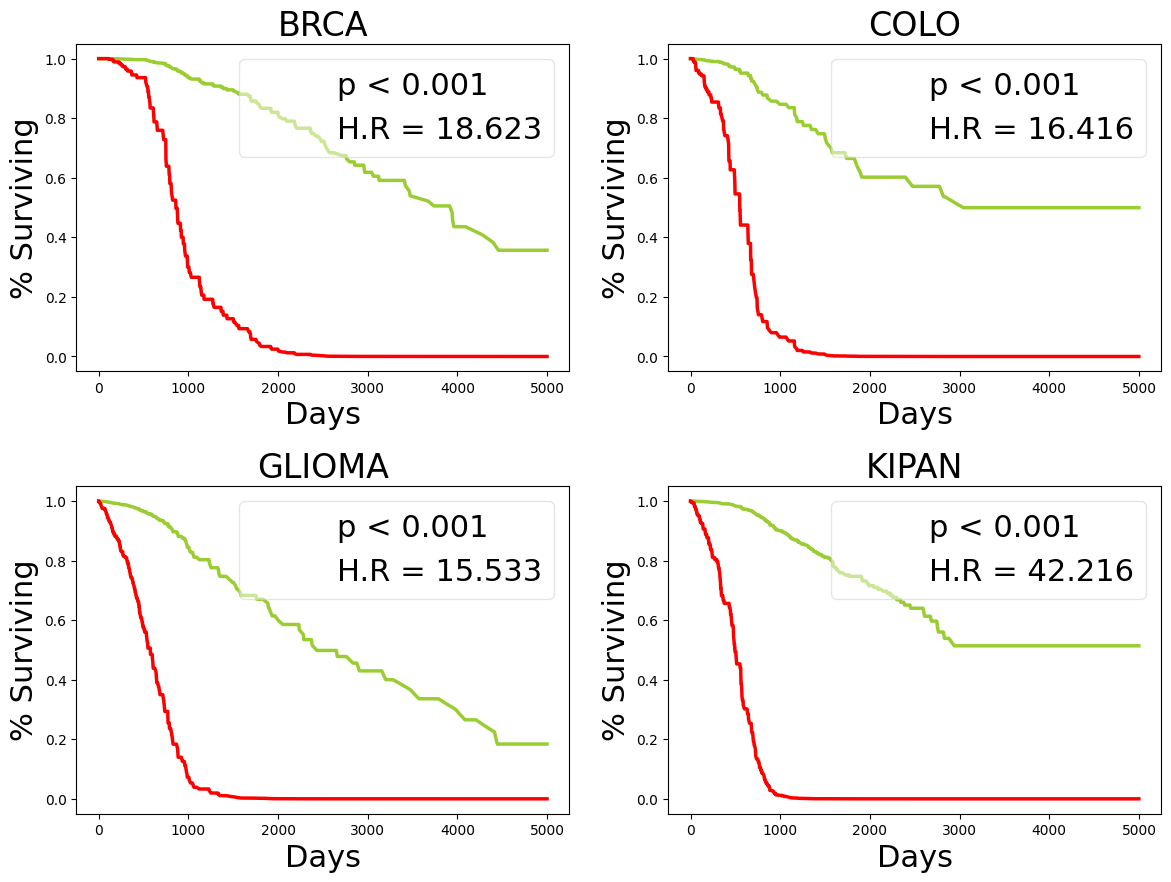

In [6]:
PostAnal.SurvivalGraph(mode='each', nrows=2, ncols=2 )
if Positive:
    type= 'Pos'
else:
    type='Neg'
#plt.savefig('./Figures/SurvivalGraph'+str(type)+'_'+str(NumGene_CL)+'.png')    

## UMAP analysis

In [7]:
PostAnal.PerformUMPA(PostAnal.ExGeneLocList, random_state=42, metric='cosine',n_neighbors=20,min_dist=0.9)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.9, n_neighbors=20, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


### Patient representation 

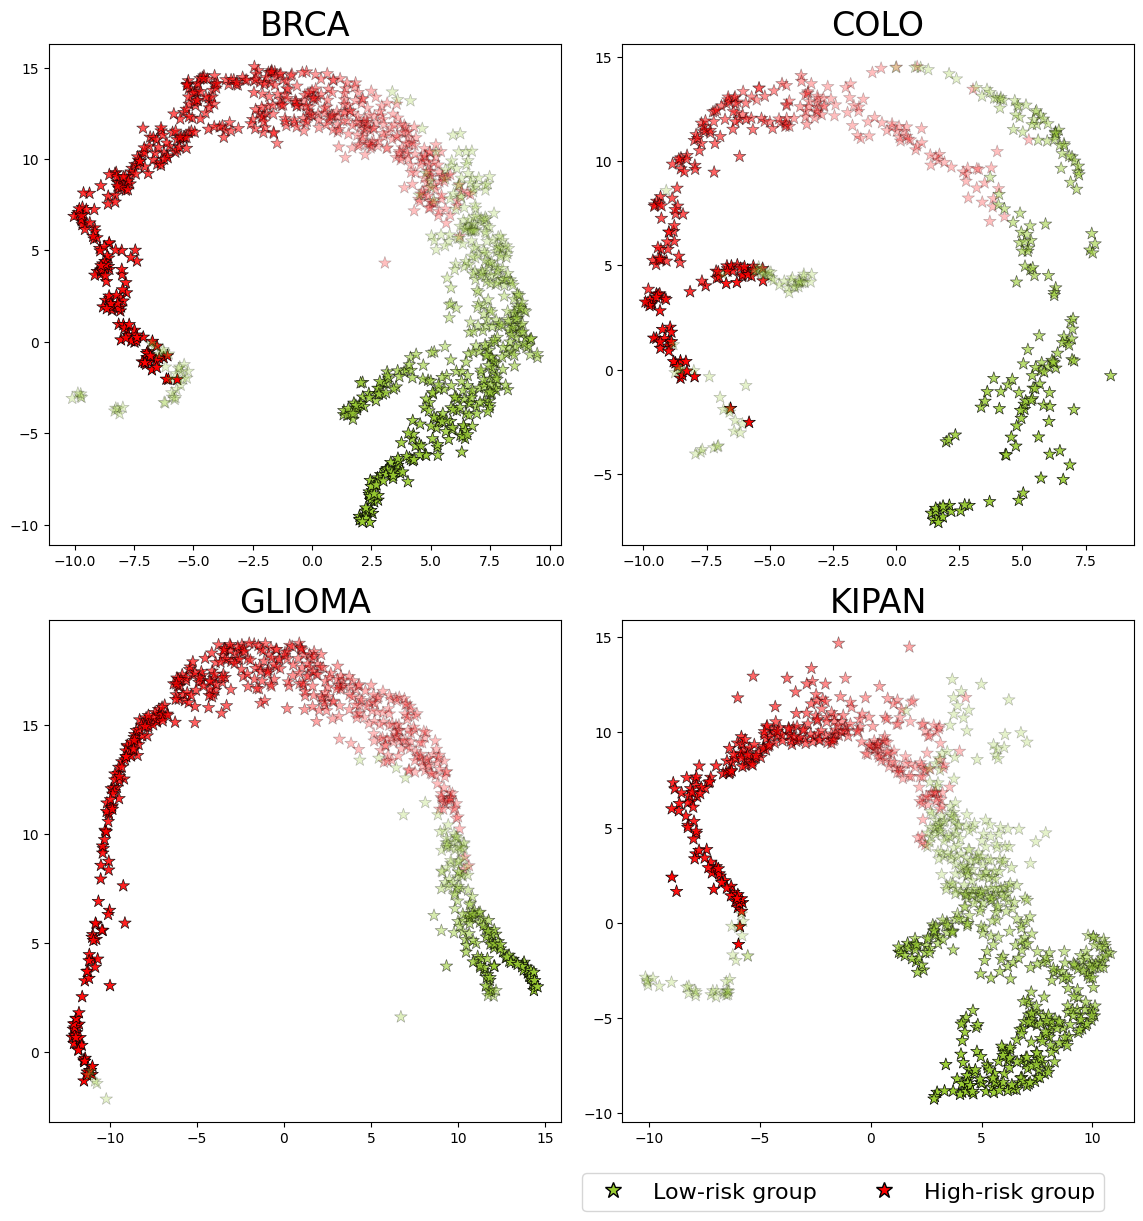

In [8]:
PostAnal.IndRepresent(mode='each',nrows=2,ncols=2)
#plt.savefig('./Figures/2D_Repr'+str(type)+'_'+str(NumGene_CL)+'.png')    

### Patient and gene representation 

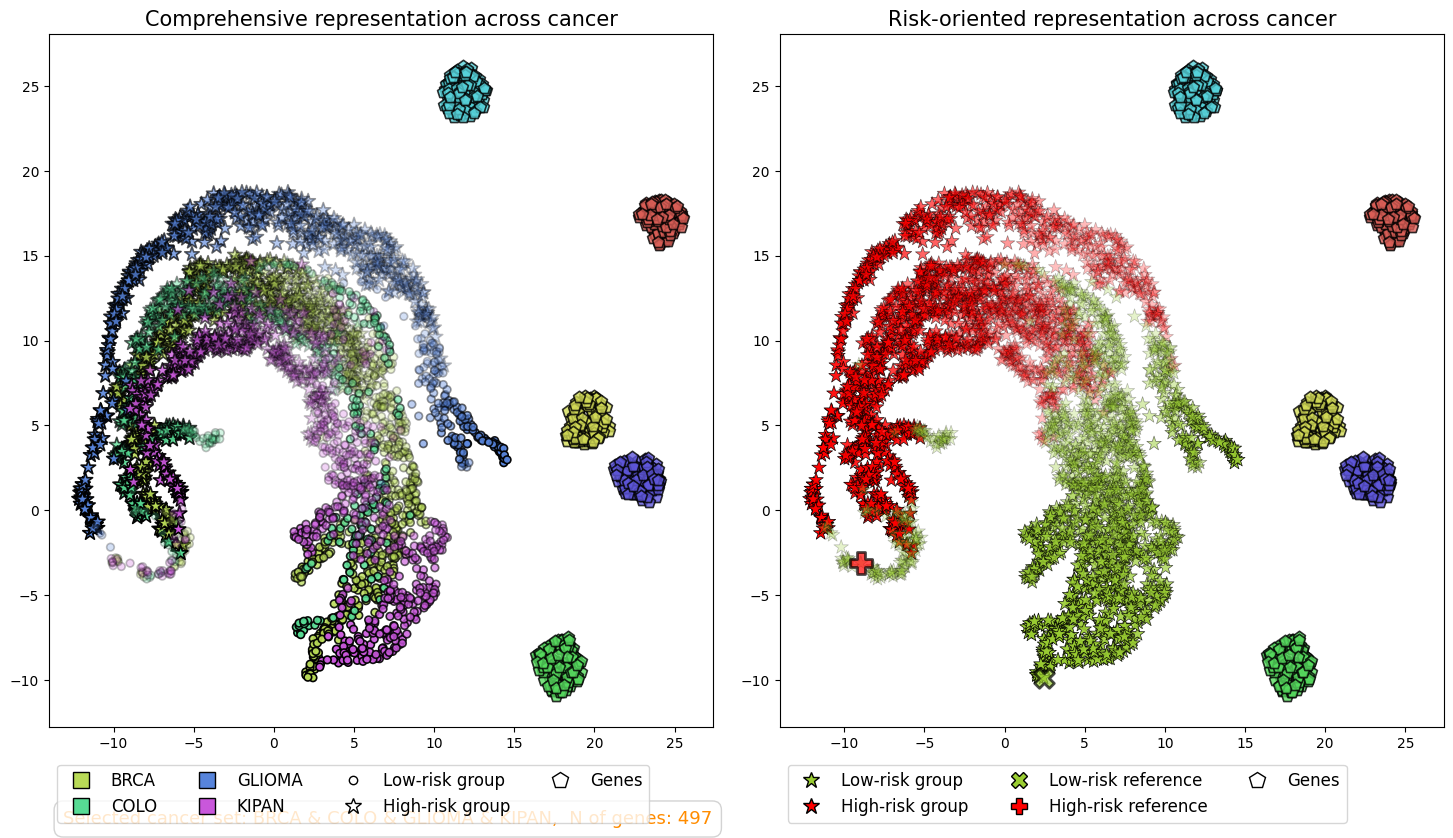

In [9]:
PostAnal.IndGeneRepresent(mode='whole',nrows=2,ncols=2)

## Evaluation on Cohen's d

In [10]:
def CoDbyCL (CoDRes, Pos=False):
    
    CoDResPD = pd.DataFrame()

    for i in range(CoDRes.shape[0]):
        for j in range(PostAnal.NCL_Feat):
            SubCoDResPD = pd.DataFrame(CoDRes[i][SelGeneFeatLabel==j])
            SubCoDResPD['Tumor'] = UniqTumorType[i]
            SubCoDResPD['Cluster'] = 'CL'+str(j+1)
            SubCoDResPD['Gene'] = np.array(PostAnal.SelectedGeneNameList)[SelGeneFeatLabel==j]
            SubCoDResPD['AdjP'] = PostAnal.AdjpRes[i][SelGeneFeatLabel==j]
            CoDResPD = pd.concat([CoDResPD,SubCoDResPD], axis=0)

    CoDResPD = CoDResPD.rename(columns={0:"Cohen's d"}).reset_index(drop=True)        


    if Pos:
        CoDResPD = CoDResPD[CoDResPD["Cohen's d"]>0]
    else:
        CoDResPD = CoDResPD[CoDResPD["Cohen's d"]<0]
    
    CoDResPD["Cohen's d"] = abs(CoDResPD["Cohen's d"])
    
    return CoDResPD
       
    

### Summary of Cohen's d

In [11]:
SelGeneFeatLabel = PostAnal.FeatGroupLables[[PostAnal.GeneNametoVecLoc[i] for i in PostAnal.SelectedGeneNameList]]
UniqTumorType = PostAnal.UniqueTumors

if Positive:
    CoDResPD = CoDbyCL(PostAnal.CoDRes, Pos=True)
else:
    CoDResPD = CoDbyCL(PostAnal.CoDRes, Pos=False)

# Optional
CoDResPD = CoDResPD[CoDResPD['AdjP'] < 0.05]

#SummaryCoDResPD =  CoDResPD.loc[CoDResPD.groupby(['Tumor','Cluster'])["Cohen's d"].idxmax()]
SummaryCoDResPD =  CoDResPD.loc[CoDResPD.groupby(['Tumor'])["Cohen's d"].idxmax()]
SummaryCoDResPD = SummaryCoDResPD[['Tumor','Cluster','Gene',"Cohen's d", "AdjP"]]

#SummaryCoDResPD.to_csv('./MetricTables/TopGenebyCohenD_'+str(type)+'_'+str(NumGene_CL)+'.csv')
#CoDResPD.groupby(['Tumor','Cluster']).mean().to_csv('./MetricTables/CLPerformancebyCohenD_'+str(type)+'_'+str(NumGene_CL)+'.csv')

### Visualization of Cohen's d

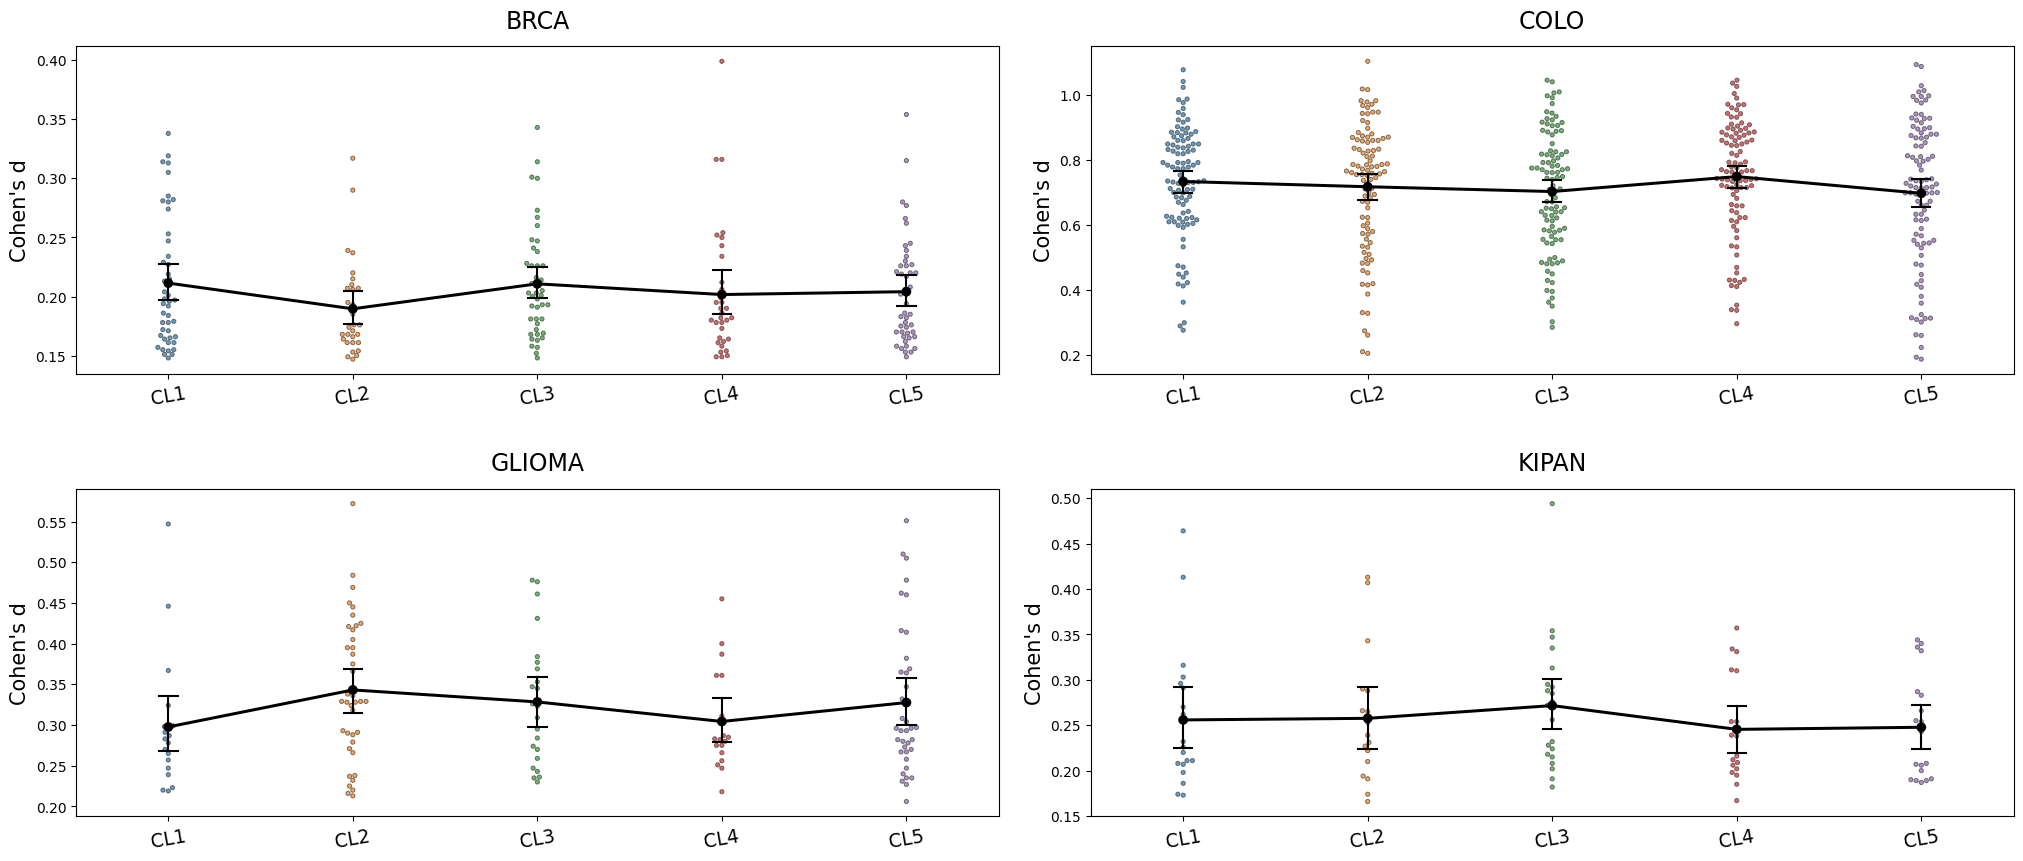

In [12]:
plt.figure(figsize=(25,10))

for numi, i in enumerate(UniqTumorType):
    plt.subplot(2,2,numi+1)
    #sns.swarmplot(x="Cluster", y="Cohen's d", data=CoDResPD[(CoDResPD['Tumor'] == i) &(CoDResPD["Cohen's d"] > 0.2) ],  size=2, alpha=0.7, linewidth=0.7, edgecolor='gray',zorder=1)
    sns.swarmplot(x="Cluster", y="Cohen's d", data=CoDResPD[(CoDResPD['Tumor'] == i)  ],  size=3., alpha=0.7, linewidth=0.7, edgecolor='gray',zorder=1)
    #sns.pointplot(x ='Cluster', y="Cohen's d", data=CoDResPD[(CoDResPD['Tumor'] == i) &(CoDResPD["Cohen's d"] > 0.2)], estimator=npMean, color='black', 
    #              linestyles='-', capsize=0.1, err_style='bars',errwidth=1.5, markers='o', alpha=1)
    sns.pointplot(x ='Cluster', y="Cohen's d", data=CoDResPD[CoDResPD['Tumor'] == i], estimator=npMean, color='black', 
                  linestyles='-', capsize=0.1, err_style='bars',errwidth=1.5, markers='o', alpha=1, scale=0.8)
    
    
    plt.xticks(fontsize=13.5, rotation=10)
    plt.xlabel('', size=16, labelpad=10)
    plt.title(i, size=17, pad=13)
    plt.ylabel("Cohen's d", size=15 )
    #plt.ylim(bottom=-0.05)
    plt.subplots_adjust(hspace=0.35,wspace=0.1)

if Positive:
    type= 'Pos'
else:
    type='Neg'
    
#plt.savefig('./Figures/CoendPlot_'+str(type)+'_'+str(NumGene_CL)+'.png')    